# Roger Federer Match Length History Pilot Analysis

Now this is exciting ! We will now go beyond analysing generalized (ie. non player specific) match length data and take a look at a specific player : the GOAT Roger Federer. There are several reasons for this choice (many matches at the top level, long career spanning more than two decades, evolution in terms of playstyle) but mainly Federer is my tennis hero.

The goal here is to obtain a series of weighted variables which would allow us to predict the length of a Roger Federer match against a given opponent, under a given set of match conditions.

In [2]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
### CLEAN FEDERER MATCHES TABLES ###

atp = pd.read_csv("atp_cat.csv")

fed_won = atp[atp["winner_name"] == "Roger Federer"]    # 1163 wins
fed_lost = atp[atp["loser_name"] == "Roger Federer"]    # 261 loses (82% winrate)

# We'll drop all of Federer's information except his age
fed_won = fed_won.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
fed_won = fed_won.rename(columns={"winner_age": "fed_age", "winner_rank": "fed_rank", "winner_rank_points": "fed_rank_points",
                                  "loser_name":"opp_name", "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_ioc":"opp_ioc", "loser_age":"opp_age",
                                  "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
fed_won["fed_won"] = "1"

fed_lost = fed_lost.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
fed_lost = fed_lost.rename(columns={"loser_age": "fed_age", "loser_rank": "fed_rank", "loser_rank_points": "fed_rank_points",
                                    "winner_name":"opp_name", "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_ioc":"opp_ioc", "winner_age":"opp_age",
                                    "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
fed_lost["fed_won"] = "0"

fed = pd.concat([fed_won, fed_lost])
fed.head(5)    # Clean Table of all Roger Federer ATP matches

,Unnamed: 0,tourney_name,surface,tourney_level,tourney_date,fed_age,opp_name,opp_hand,opp_ht,opp_ioc,opp_age,score,best_of,round,minutes,fed_rank,fed_rank_points,opp_rank,opp_rank_points,fed_won
24932,3086,Toulouse,Hard,A,19980928,17.138946,Guillaume Raoux,R,180.0,FRA,28.618754,6-2 6-2,3,R32,60.0,878.0,9.0,45.0,859.0,1
24941,3095,Toulouse,Hard,A,19980928,17.138946,Richard Fromberg,R,196.0,AUS,28.418891,6-1 7-6(5),3,R16,85.0,878.0,9.0,43.0,927.0,1
25666,251,Marseille,Hard,A,19990201,17.483915,Carlos Moya,R,190.0,ESP,22.431211,7-6(1) 3-6 6-3,3,R32,113.0,243.0,173.0,5.0,3178.0,1
25682,267,Marseille,Hard,A,19990201,17.483915,Jerome Golmard,L,188.0,FRA,25.396304,6-7(6) 7-6(5) 7-6(5),3,R16,140.0,243.0,173.0,63.0,743.0,1
25849,479,Rotterdam,Carpet,A,19990215,17.522245,Guillaume Raoux,R,180.0,FRA,29.002053,6-7(4) 7-5 7-6(3),3,R32,149.0,178.0,262.0,71.0,691.0,1


## Federer Generalities

### Surface

In [4]:
fed_surface = pd.pivot_table(fed, values="minutes", index = ["best_of", "opp_hand"], columns=["surface"]) # average duration per surface
display(fed_surface)
fed['surface'].value_counts(ascending=True)

surface             Carpet        Clay       Grass        Hard
best_of opp_hand                                              
3       L          61.4000   95.363636   72.900000   82.361111
        R          93.1875   88.393750   89.388235   89.526678
5       L              NaN  161.625000  131.315789  131.050000
        R         170.7500  134.097561  124.031579  130.214634

Carpet     57
Grass     209
Clay      280
Hard      878
Name: surface, dtype: int64

## Simple Regression Decision Tree

We will create a simple decision tree using five features :
- Surface  
- Best of  
- Opponent hand  
- Opponent height  
- Ranking difference  

In [5]:
### FORMAT TABLE FOR DECISION TREE REGRESSION ###

fed1 = fed[["minutes", "surface", "opp_hand", "opp_ht"]]
fed1["rank_diff"] = fed["fed_rank"] - fed["opp_rank"]

# One-Hot Encoding
fed1 = pd.get_dummies(data=fed1, columns=["surface", "opp_hand"])

fed1 = fed1.dropna(axis=0, how='any')

fed1.head(5)

C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,minutes,opp_ht,rank_diff,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,opp_hand_L,opp_hand_R
24932,60.0,180.0,833.0,0,0,0,1,0,1
24941,85.0,196.0,835.0,0,0,0,1,0,1
25666,113.0,190.0,238.0,0,0,0,1,0,1
25682,140.0,188.0,180.0,0,0,0,1,1,0
25849,149.0,180.0,107.0,1,0,0,0,0,1


In [6]:
fed1.dtypes


minutes           float64
opp_ht            float64
rank_diff         float64
surface_Carpet      uint8
surface_Clay        uint8
surface_Grass       uint8
surface_Hard        uint8
opp_hand_L          uint8
opp_hand_R          uint8
dtype: object

In [46]:
### DECISION TREE ###

# SETUP #

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

target='minutes'

MAX_DEPTH=np.arange(3, 10)
MIN_SAMPLE=[0.5, 0.4, 0.3, 0.2, 0.1, 0.05]

scores = []   # sklearn Decision Tree score (max = 1)
MSE = []      # Mean Squared Error
RMSE = []     # Root Mean Squared Error

X = fed1.drop([target], axis=1)
Y = fed1[target]

X = scale(X)
Y = scale(Y)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3)

Max-depth : 3
score : 0.11811198123536226.
MSE : 0.8789579943462362.
RMSE : 0.4394789971731181.
Max-depth : 4
score : 0.1524078963662603.
MSE : 0.875929811171291.
RMSE : 0.4379649055856455.
Max-depth : 5
score : 0.19501143509848984.
MSE : 0.9083721903838907.
RMSE : 0.45418609519194536.
Max-depth : 6
score : 0.2410107870632101.
MSE : 0.9404096690420818.
RMSE : 0.4702048345210409.
Max-depth : 7
score : 0.28711899231577476.
MSE : 1.0300402838159517.
RMSE : 0.5150201419079758.
Max-depth : 8
score : 0.33720895494638314.
MSE : 1.1578379639318066.
RMSE : 0.5789189819659033.
Max-depth : 9
score : 0.3915243592267714.
MSE : 1.221146190744059.
RMSE : 0.6105730953720295.


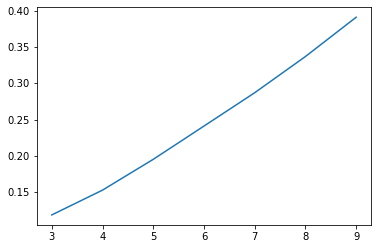

In [47]:
# MAX DEPTH LOOP #

scores = []   # sklearn Decision Tree score (max = 1)
MSE = []      # Mean Squared Error
RMSE = []     # Root Mean Squared Error

for i in MAX_DEPTH :

    print(f"Max-depth : {i}")

    dtr = DecisionTreeRegressor(max_depth=i)

    dtr.fit(Xtrain, Ytrain)

    score = dtr.score(Xtrain, Ytrain)   
    scores.append(score)
    print(f"score : {score}.")

    Ypred = dtr.predict(Xtest)

    mse = mean_squared_error(Ytest, Ypred)  # mean of (y_true - y_pred)**2

    MSE.append(mse)
    print(f"MSE : {mse}.")
    RMSE.append(mse*(1/2.0))
    print(f"RMSE : {mse*(1/2.0)}.")

plt.plot(MAX_DEPTH, scores)

Min sample : 0.5
score : 0.05679474648903582.
MSE : 0.8527513371534721.
RMSE : 0.42637566857673603.
Min sample : 0.4
score : 0.05679474648903582.
MSE : 0.8527513371534722.
RMSE : 0.4263756685767361.
Min sample : 0.3
score : 0.11923392963041235.
MSE : 0.8813595489887838.
RMSE : 0.4406797744943919.
Min sample : 0.2
score : 0.1546049372776659.
MSE : 0.9544946689080088.
RMSE : 0.4772473344540044.
Min sample : 0.1
score : 0.1703738771963198.
MSE : 0.990891130364859.
RMSE : 0.4954455651824295.
Min sample : 0.05
score : 0.22447874364917864.
MSE : 1.0346228063010205.
RMSE : 0.5173114031505103.
[0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
[0.05679474648903582, 0.05679474648903582, 0.11923392963041235, 0.1546049372776659, 0.1703738771963198, 0.22447874364917864]


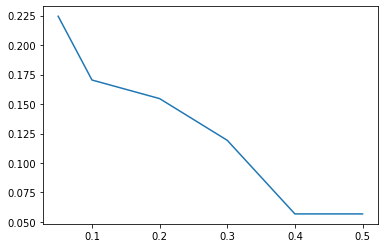

In [48]:
# MIN SAMPLE LOOP #

scores = []   # sklearn Decision Tree score (max = 1)
MSE = []      # Mean Squared Error
RMSE = []     # Root Mean Squared Error 

for i in MIN_SAMPLE :

    print(f"Min sample : {i}")

    dtr = DecisionTreeRegressor(min_samples_split=i)

    dtr.fit(Xtrain, Ytrain)

    score = dtr.score(Xtrain, Ytrain)   
    scores.append(score)
    print(f"score : {score}.")

    Ypred = dtr.predict(Xtest)

    mse = mean_squared_error(Ytest, Ypred)  # mean of (y_true - y_pred)**2

    MSE.append(mse)
    print(f"MSE : {mse}.")
    RMSE.append(mse*(1/2.0))
    print(f"RMSE : {mse*(1/2.0)}.")

print(MIN_SAMPLE)
print(scores)
plt.plot(MIN_SAMPLE, scores)

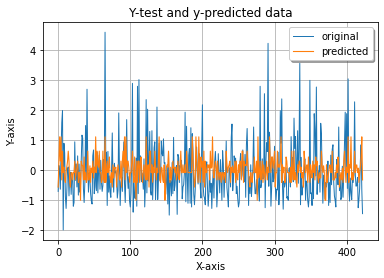

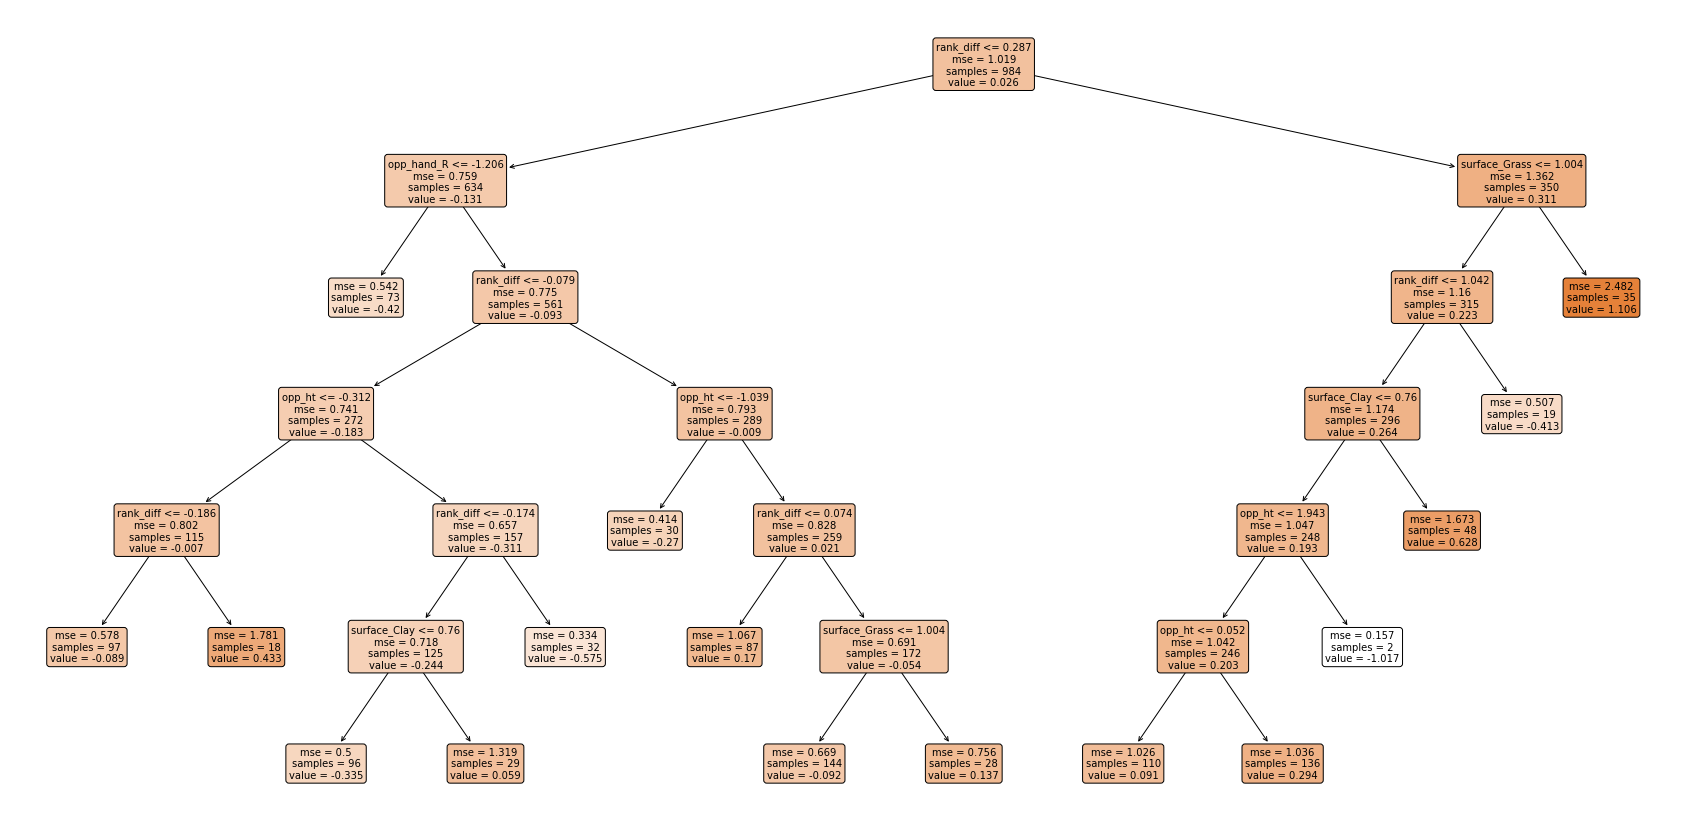

In [31]:
### TREE DISPLAY ###

from sklearn import tree

dtr = DecisionTreeRegressor(max_depth=6, min_samples_split=.1)

dtr.fit(Xtrain, Ytrain)

Ypred = dtr.predict(Xtest)

x_ax = range(len(Ytest))
plt.plot(x_ax, Ytest, linewidth=1, label="original")
plt.plot(x_ax, Ypred, linewidth=1.1, label="predicted")
plt.title("Y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

plt.figure(figsize=(30,15))
tree.plot_tree(dtr,
          filled=True,
          rounded=True,
          fontsize=10,
          feature_names=["opp_ht", "rank_diff", "surface_Carpet", "surface_Clay", "surface_Grass", "surface_Hard", "opp_hand_L", "opp_hand_R"])

plt.savefig('tree_high_dpi', dpi=600)